# RAG 시스템 보기


In [1]:
import warnings
from retrieval import load_vectorstore_retriever_embeddings, rag
from model import llm_load
import json

warnings.filterwarnings("ignore")

# 1. 벡터스토어 로드
vectorstore, retriever, embeddings = load_vectorstore_retriever_embeddings("RAG/vectorDB")

# 2. LLM 한 번만 로드 (재사용)
llm = llm_load()

/home/sehan/miniconda/envs/knowledge_conflict/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


벡터스토어 로드 중
검색기 로드 중
검색기 로드 완료


Loading checkpoint shards: 100%|██████████| 5/5 [00:45<00:00,  9.17s/it]


In [2]:
#3. test 데이터셋 가져오기
with open("datasets/popqa_dataset/qa_dataset.json", "r") as f:
    pop_qa = json.load(f)

with open("datasets/nq_dataset/qa_dataset.json", "r") as f:
    nq_qa = json.load(f)

with open("datasets/triviaqa_dataset/qa_dataset.json", "r") as f:
    trivia_qa = json.load(f)

with open("datasets/bioasq_dataset/qa_dataset.json", "r") as f:
    bioasq_qa = json.load(f)

### 테스트 데이터셋 랜덤 추출

In [3]:
from set_data import extract_random_qa

pop_qa_sampled = extract_random_qa(pop_qa, num_qa=260)
nq_qa_sampled = extract_random_qa(nq_qa, num_qa=260)
trivia_qa_sampled = extract_random_qa(trivia_qa, num_qa = 261)
bioasq_qa_sampled = extract_random_qa(bioasq_qa, num_qa=261)

### 최종 테스트 데이터셋 만들기

In [4]:
import os
total_sampled = pop_qa_sampled + nq_qa_sampled + trivia_qa_sampled + bioasq_qa_sampled

for idx, item in enumerate(total_sampled):
    item["ids"] = str(idx)
    if "idx" in item:
        del item["idx"]

if not os.path.exists("datasets/total_qa_sampled"):
    os.makedirs("datasets/total_qa_sampled")

if not os.path.exists("datasets/total_qa_sampled/qa_dataset.json"):
    with open("datasets/total_qa_sampled/qa_dataset.json", "w") as f:
        json.dump(total_sampled, f, ensure_ascii=False, indent=2)

# Test with No RAG

In [5]:
from tqdm import tqdm
from model import llm_answer
from langchain_core.prompts import PromptTemplate
from prompt_template import NO_RAG_PROMPT_TEMPLATE


# Test With No RAG

In [7]:
output_file = "output/output_with_no_rag.jsonl"

PROMPT = PromptTemplate(template=NO_RAG_PROMPT_TEMPLATE, input_variables=["question"])

for item in tqdm(total_sampled[:],desc="No RAG 처리중"):
    question = item["question"]
    prompt = PROMPT.format(question=question)
    answer = llm_answer(llm[0], llm[1], prompt)
    ground_truth = item["answers"]

    result = {
        "question": question,
        "answers": answer,
        "ground_truth": ground_truth
    }

    with open(output_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

print("저장 완료") # -> output/output_with_no_rag.jsonl

No RAG 처리중: 100%|██████████| 1042/1042 [38:42<00:00,  2.23s/it] 

저장 완료


# Test with Wikipedia RAG

In [ ]:
# 3. RAG 실행
from tqdm import tqdm
# 배치 설정 (수동으로 변경)

output_file = f"output/output_with_base_rag.jsonl"  # JSON 형식


for item in tqdm(total_sampled[:], desc="RAG 처리중"):
    question = item["question"]
    rag_output = rag(vectorstore, question, llm)
    ground_truth = item["answers"]

    # Document 객체 → dict 변환
    docs_serialized = [
        {"page_content": doc.page_content, "metadata": doc.metadata}
        for doc in rag_output['source_documents']
    ]
    
    result = {
        "question": question,
        "answers": rag_output['answer'],
        "ground_truth": ground_truth,
        "docs": docs_serialized
    }
    
    # 한 줄씩 바로 저장 (append 모드)
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")
    
print(f"저장 완료")  # -> output/output_with_base_rag.jsonl

RAG 처리중: 100%|██████████| 1042/1042 [35:08<00:00,  2.02s/it]

저장 완료


# Test with API RAG

In [ ]:
#이제 API로 평가하면 됨
from tqdm import tqdm

output_file = f"output/output_with_base_api_rag.jsonl" 

from api_rag import web_rag

for item in tqdm(total_sampled[:], desc="API RAG 처리중"):
    question = item["question"]
    rag_output = web_rag(question,llm)
    ground_truth = item["answers"]

    # Document 객체 → dict 변환
    docs_serialized = [
        {"page_content": doc["title"] + ": " + doc["paragraph"]}
        for doc in rag_output['source_documents']
    ]

    result = {
        "question": question,
        "answers": rag_output['answer'],
        "ground_truth": ground_truth,
        "docs": docs_serialized
    }

     # 한 줄씩 바로 저장 (append 모드)
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

print(f"저장 완료")  # -> output/output_with_base_api_rag.jsonl
    

API RAG 처리중:   0%|          | 0/1042 [00:08<?, ?it/s]


KeyError: 'page_content'

### 평가하기

### 정확도 계산

In [9]:
from acc_prec import load_results, calculate_accuracy_by_dataset, calculate_precision_by_datasets

#### No RAG

In [10]:
dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

results = load_results("output/output_with_no_rag.jsonl")
no_rag_accuracy = calculate_accuracy_by_dataset(results, dataset_sizes)

In [12]:
print("=== 데이터셋별 정확도 ===")
for name, accuracy in no_rag_accuracy.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 정확도 ===
popqa: 25.4%
nq: 28.5%
triviaqa: 74.3%
bioasq: 54.0%
overall: 45.6%


#### RAG

In [14]:
# 데이터셋 크기 (순서대로: popqa, nq, triviaqa, bioasq)
dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

# 결과 로드 및 정확도 계산
results = load_results("output/output_with_base_rag.jsonl")
rag_accuracy = calculate_accuracy_by_dataset(results, dataset_sizes)
precision_dict = calculate_precision_by_datasets(results, dataset_sizes)

In [15]:
print("=== 데이터셋별 검색 정밀도 ===")
for name, precision in precision_dict.items():
    print(f"{name}: {precision:.1f}%")
print("=== 데이터셋별 정확도 ===")
for name, accuracy in rag_accuracy.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 검색 정밀도 ===
popqa: 34.6%
nq: 25.4%
triviaqa: 50.2%
bioasq: 25.4%
overall: 33.9%
=== 데이터셋별 정확도 ===
popqa: 11.5%
nq: 5.8%
triviaqa: 16.5%
bioasq: 6.9%
overall: 10.2%


### BASELINE RAG 시각화

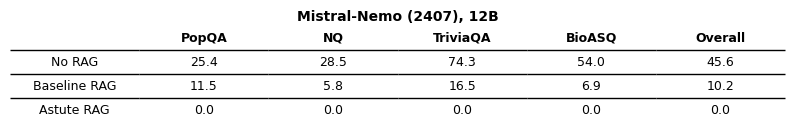

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
data = {
    'PopQA': [0, 0, 0],
    'NQ': [0, 0, 0],
    'TriviaQA': [0, 0, 0],
    'BioASQ': [0, 0, 0],
    'Overall': [0, 0, 0]
}

#No RAG 정확도 업데이트
for key in data:
    acc = no_rag_accuracy[str(key).lower()]
    data[key][0] = round(acc, 1)
    
# Baseline RAG 정확도로 업데이트
for key in data:
    acc = rag_accuracy[str(key).lower()]
    data[key][1] = round(acc, 1)  

df = pd.DataFrame(data, index=['No RAG', 'Baseline RAG', 'Astute RAG'])

fig, ax = plt.subplots(figsize=(8, 1.5))
ax.axis('off')

col_labels = [''] + list(df.columns)
header_text = [['Mistral-Nemo (2407), 12B', '', '', '', '']]

table = ax.table(
    cellText=[[idx] + list(row) for idx, row in zip(df.index, df.values)],
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for j in range(len(col_labels)):
    table[(0, j)].set_facecolor('#ffffff')
    table[(0, j)].set_text_props(fontweight='bold')
    table[(0, j)].visible_edges = 'B' 

for i in range(1, len(df) + 1):
    for j in range(len(col_labels)):
        table[(i, j)].set_facecolor('#ffffff')
        table[(i, j)].visible_edges = 'B' if i < len(df) else ''

plt.text(0.5, 0.95, 'Mistral-Nemo (2407), 12B', ha='center', va='bottom', 
         fontsize=10, fontweight='bold', transform=ax.transAxes)

plt.tight_layout()
plt.show()